In [36]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank, DyadicFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import *
import time

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [37]:
data = np.load("data.npy")
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array

"Add interference to the data"
B1 = data + 1000 *np.sin(2 * np.pi * 6.4 * t) + 50 * signal.square(2 * np.pi * .5* t)
B2 = data + 100 *np.sin(2 * np.pi * 6.4 * t) + 10* signal.square(2 * np.pi * .5 * t)
B3 = data + -500 *np.sin(2 * np.pi * 6.4 * t) + 100* signal.square(2 * np.pi * .5 * t)
B = np.vstack((B1,B2, B3))

#### Create Transform Object and Analysis Filters

In [38]:
fb = DyadicFilterBank(wavelet=Morlet() , fs=sample_rate, N=5000, real=True, dj = 1/8, s_max=1)
transform = Transform(
    data=B[0],
    fs = sample_rate,
    filterbank=fb,
)

In [39]:
#### WAICUP
start = time.time()
def WAICUP(w1, w2):
    D = w2 - w1  # shape (J, T), complex

    # 1) correlations (eqs 6–7), using conjugate inner products
    C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
    C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

    # 2) gain estimate K̂ per scale (eq 8)
    K_hat = C2 / C1                          # shape (J,)
    # (optionally force to real if you know K is real:)
    K_hat = K_hat

    # 3) residuals (eq 9)
    A = (w1-w2) / (K_hat[:,None]-1)  # shape (J, T), complex

    # 4) ambient‑field estimate X(s,τ) (eq 10)
    X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 
    return X, A

w1 = transform.forward(B[0], mode='full')
w2 = transform.forward(B[1], mode='full')
w3 = transform.forward(B[2], mode='full')

X1, A1 = WAICUP(w1, w2)
X2, A2 = WAICUP(w1, w3)
X3, A3 = WAICUP(w2, w3)

abs_A1 = np.abs(X1)  # shape (J, T)
abs_A2 = np.abs(X2)  # shape (J, T)
abs_A3 = np.abs(X3)  # shape (J, T)

# Stack the absolute values along a new axis
abs_A_stack = np.stack([abs_A1, abs_A2, abs_A3], axis=0)  # shape (3, J, T)

# Find the indices of the maximum absolute A values
max_indices = np.argmin(abs_A_stack, axis=0)  # shape (J, T)

# Initialize X_result with the same shape as X1, X2, X3
X_result = np.zeros_like(X1, dtype=X1.dtype)

# Use advanced indexing to select the corresponding X values
# Create a meshgrid of indices for J and T
j_indices, t_indices = np.indices(max_indices.shape)

# Select X values based on max_indices
X_result[j_indices, t_indices] = np.where(
    max_indices == 0, X1[j_indices, t_indices],
    np.where(max_indices == 1, X2[j_indices, t_indices], X3[j_indices, t_indices])
)
result = transform.inverse(X_result)
end = time.time()
print("Time taken for WAICUP: ", end - start)

Time taken for WAICUP:  0.2915077209472656


Raw Error 1:  708.6532492903195
Raw Error 2:  71.01914198617644
Raw Error 3:  366.71640025880635
Cleaned Error:  3.9045944406762896


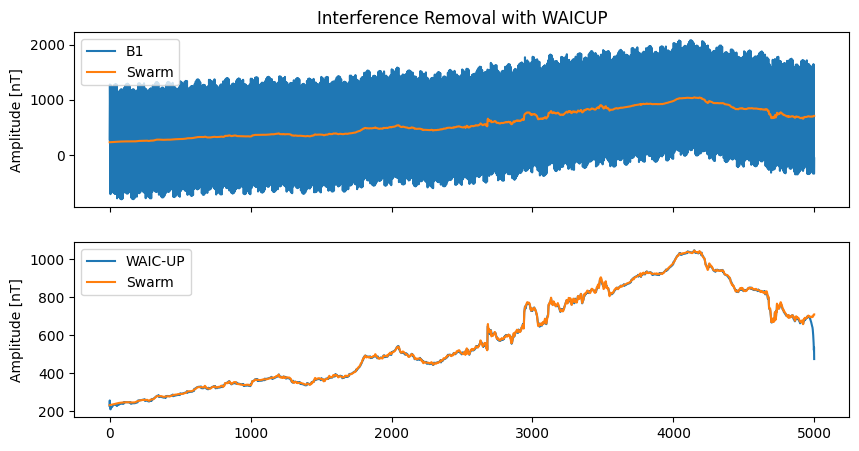

In [42]:
print("Raw Error 1: ", np.sqrt(((B[0,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Raw Error 2: ", np.sqrt(((B[1,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Raw Error 3: ", np.sqrt(((B[2,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Cleaned Error: ", np.sqrt(((data[1000:-1000]-result[:5000][1000:-1000])**2).mean(axis=0)))

%matplotlib inline
fig, ax = plt.subplots(2,1, sharex=True, figsize=(10, 5))


ax[0].plot(B[0], label='B1')
ax[0].plot(data, label='Swarm')
ax[1].plot(result, label='WAIC-UP')
ax[1].plot(data, label='Swarm')
ax[0].set_title('Interference Removal with WAICUP')
ax[0].set_ylabel('Amplitude [nT]')

ax[1].set_ylabel('Amplitude [nT]')
ax[0].legend()
ax[1].legend()
plt.show()